<h1> 
Investigate users shopping patterns #4

In [148]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits import mplot3d

In [3]:
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
prior = pd.read_csv('data/order_products__prior.csv')
train = pd.read_csv('data/order_products__train.csv')
sample = pd.read_csv('data/sample_submission.csv')
departments = pd.read_csv('data/departments.csv')

In [94]:
all_orders = prior.append(train)

merge = pd.merge(all_orders, orders, on='order_id')
merge = merge[['user_id', 'product_id']]
products = products.rename(columns={' product_id': 'product_id'})
merge = pd.merge(merge, products[['product_id', 'product_name', 'aisle_id']], on='product_id')
merge = merge.sort_values('user_id')
user_item = merge[['user_id', 'product_name', 'product_id']][:5000000]

user_item

,user_id,product_name,product_id
18501477,1,Aged White Cheddar Popcorn,26088
19738755,1,Organic String Cheese,25133
19133978,1,Pistachios,10258
22448275,1,Original Beef Jerky,12427
22444847,1,Original Beef Jerky,12427
...,...,...,...
28870517,30588,Orange,23540
5647735,30588,Seedless Red Grapes,4920
20474045,30588,Organic Deep Dark Sea Salt Chocolate,37496
21340747,30588,Organic White Cheddar Popcorn,29370


<h2>1)User-Item matrix

In [95]:
user_item_matrix = user_item.pivot_table(index='user_id', columns='product_name', aggfunc="count")
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix

product_id                               \
product_name #2 Coffee Filters #2 Cone White Coffee Filters   
user_id                                                       
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0                          0.0   
4                          0.0                          0.0   
5                          0.0                          0.0   
...                        ...                          ...   
30584                      0.0                          0.0   
30585                      0.0                          0.0   
30586                      0.0                          0.0   
30587                      0.0                          0.0   
30588                      0.0                          0.0   

                                                                    \
product_name #2 Mechanical Pencils #4 Natural Brown Coffee Filters   
user_id                                                              
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
5                              0.0                             0.0   
...                            ...                             ...   
30584                          0.0                             0.0   
30585                          0.0                             0.0   
30586                          0.0                             0.0   
30587                          0.0                             0.0   
30588                          0.0                             0.0   

                                                     \
product_name & Go! Hazelnut Spread + Pretzel Sticks   
user_id                                               
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
5                                               0.0   
...                                             ...   
30584                                           0.0   
30585                                           0.0   
30586                                           0.0   
30587                                           0.0   
30588                                           0.0   

                                                            \
product_name (70% Juice!) Mountain Raspberry Juice Squeeze   
user_id                                                      
1                                                      0.0   
2                                                      0.0   
3                                                      0.0   
4                                                      0.0   
5                                                      0.0   
...                                                    ...   
30584                                                  0.0   
30585                                                  0.0   
30586                                                  0.0   
30587                                                  0.0   
30588                                                  0.0   

                                                           \
product_name +Energy Black Cherry Vegetable & Fruit Juice   
user_id                                                     
1                                                     0.0   
2                                                     0.0   
3                                                     0.0   
4                                                     0.0   
5                                                     0.0   
...                         

<h2><font color='black'>Minimize User-Item matrix</font></h2>

<h3><font color='blue'>Components=2</font></h3>

In [182]:
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=None)
mat_reduced = svd.fit_transform(user_item_matrix)
df_mat_reduced = pd.DataFrame(mat_reduced)

df_mat_reduced

,0,1
0,1.306446,-1.260828
1,9.036430,4.329699
2,4.919168,0.874054
3,0.203417,-0.067823
4,1.166331,-0.071348
...,...,...
30583,6.848674,0.658377
30584,0.033234,0.069542
30585,2.845402,-0.492811
30586,24.054719,12.581094


<h3><font color='blue'>Components=3</font></h3>

In [150]:
svd = TruncatedSVD(n_components=3, n_iter=5, random_state=None)
mat_reduced_3 = svd.fit_transform(user_item_matrix)
mat_reduced_3

array([[ 1.30644671, -1.26076367,  2.55799642],
       [ 9.03642992,  4.32967458,  2.12917847],
       [ 4.91916793,  0.87402219, -4.39987107],
       ...,
       [ 2.84540253, -0.49274813,  0.18094888],
       [24.05471857, 12.58119977,  2.34591353],
       [ 5.47132791,  2.03197088, -0.41275799]])

<h2>2)CLUSTERING

<h3> K-Means

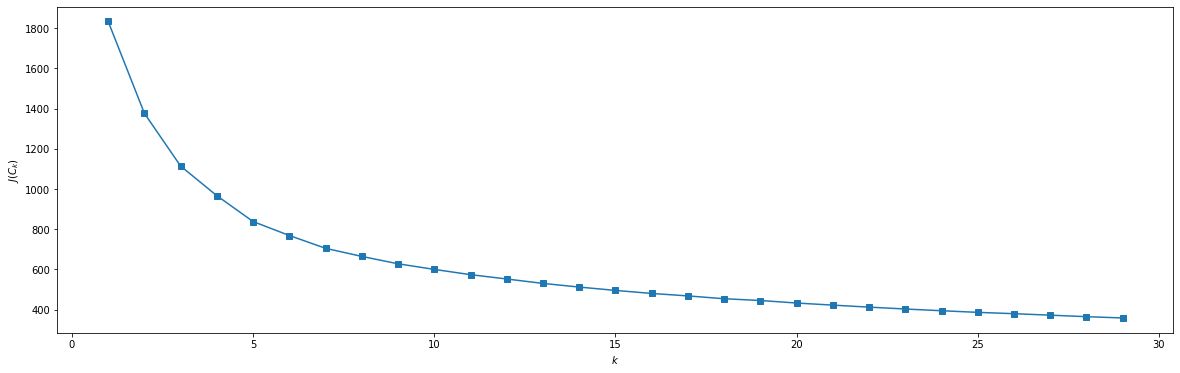

In [98]:
inertia = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(mat_reduced)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(20,6))
plt.plot(range(1, 30), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

<h3><font color='blue'>Clusters=5</font></h3>

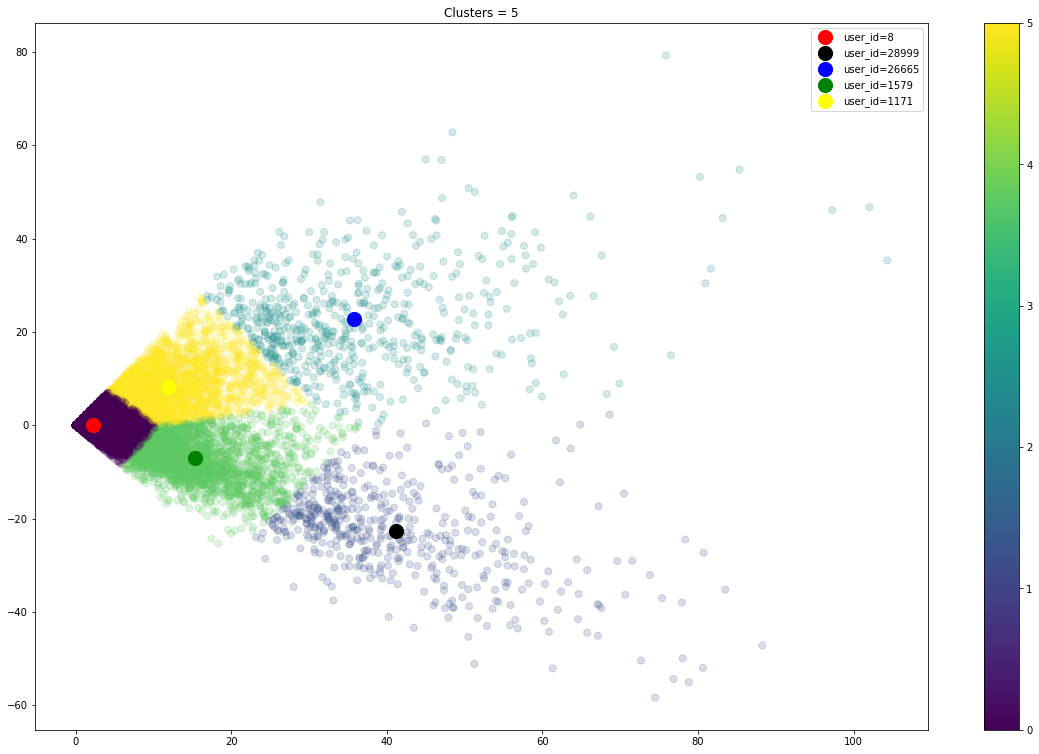

In [340]:
n_clust = 5
kmeans = KMeans(n_clusters=n_clust, random_state=0)

clusters = kmeans.fit(mat_reduced)
centers = clusters.cluster_centers_
y = clusters.labels_

plt.figure(figsize=(20,13))
plt.title('Clusters = 5')
plt.scatter(mat_reduced[:, 0], mat_reduced[:, 1], c=y, s=50, cmap='viridis', alpha=0.2)

center_users = []
users_id = []
colors=['red', 'black', 'blue', 'green', 'yellow']
for center in centers:
    #find the closest user to the cluster centroid
    user = df_mat_reduced.loc[df_mat_reduced[0]<(center[0]+0.9)]
    user = user.loc[user[0]>(center[0]-0.9)]
    user = user.loc[user[1]<(center[1]+0.9)]
    user = user.loc[user[1]>(center[1]-0.9)][:1]
    user_id = user.index[0]+1
    center_users.append(user.values.tolist()[0])
    users_id.append(user_id)

    plt.scatter(center[0], center[1], c=colors[y[user_id-1]], s=200, alpha=1, label='user_id='+str(user_id))
    
plt.legend()
plt.colorbar()
plt.clim(0,5)

<h3><font color='grey'><i>Сluster centroids</i></font></h3>

In [333]:
result = pd.DataFrame(center_users)
result['user_id'] = users_id
result

,0,1,user_id
0,2.049277,-0.145401,8
1,41.862665,-23.466433,28999
2,36.530856,21.911345,26665
3,15.264508,-6.288478,1579
4,11.638226,8.020206,1171


In [316]:
def plot_kmeans(kmeans, X, n_clusters, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    plt.figure(figsize=(20,20))
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=0.1)
    
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200)
    radii = [cdist(X[labels == i], [center]).max()
            for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.3, zorder=0.01))

<h3><font color='blue'>Clusters=15</font></h3>

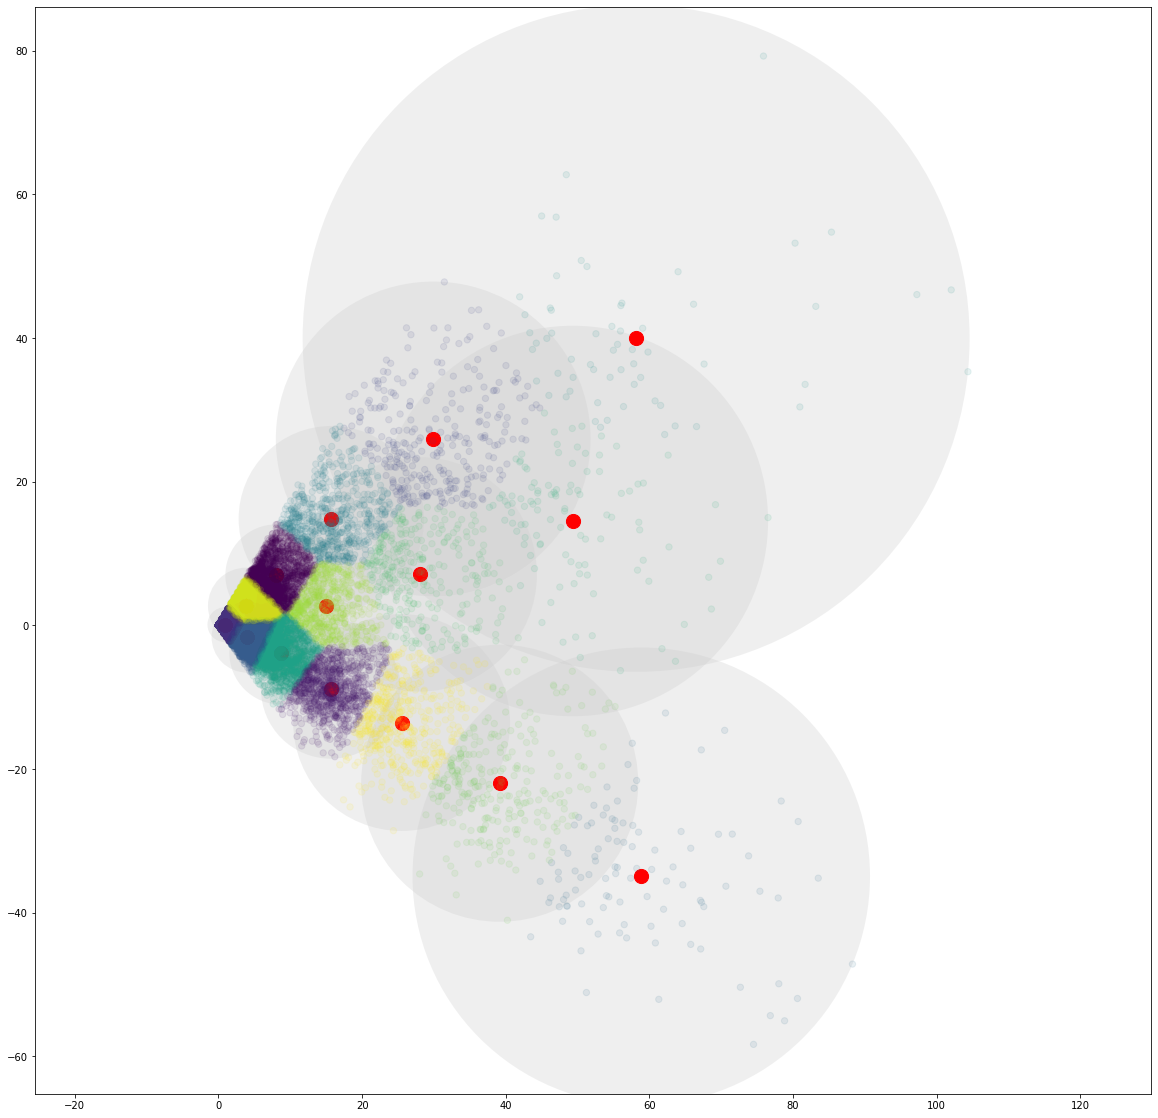

In [317]:
kmeans = KMeans(n_clusters=15, random_state=0)
plot_kmeans(kmeans, mat_reduced, n_clusters=15)

<h3><font color='grey'><i>Partitioning into 15 clusters is already unnecessary</i></font></h3>

<h3><font color='black'>Three-dimensional graph</font></h3>

/Users/anastasiia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


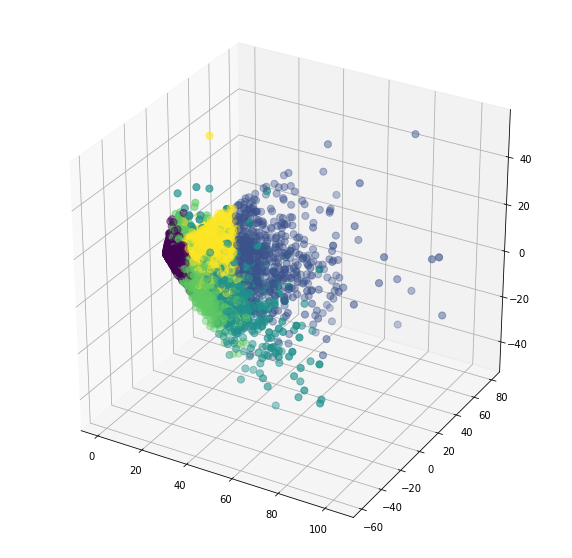

In [339]:
n_clust = 5

kmeans = KMeans(n_clusters=n_clust, random_state=0)

clusters = kmeans.fit(mat_reduced_3)
y = clusters.labels_
centers = clusters.cluster_centers_

plt.figure(figsize=(10,10))
plt.title('Clusters = 5')
ax = plt.axes(projection='3d')
ax.scatter3D(mat_reduced_3[:, 0], mat_reduced_3[:, 1], mat_reduced_3[:, 2], c=y, s=50, cmap='viridis')

<h3> DBSCAN

In [156]:
# clustering = DBSCAN(eps=3, min_samples=40).fit(mat_reduced)
# plt.figure(figsize=(20,20))
# plt.scatter(mat_reduced[:, 0], mat_reduced[:, 1], c=clustering.labels_)